In [265]:
import importlib
import plot
importlib.reload(plot)


<module 'plot' from '/home/yunzhu/github/neural-network-teach-in/plot.py'>

At this point, we've all heard of a neural network, and we've all  used them before, most likely for super academically integrous purposes. But what exactly is a neural network, and how does it work under the hood? Keep reading to find out!

In [266]:
import numpy as np
import matplotlib.pyplot as plt
import plot


### What's a neural network made of?

Before diving into the specific network we're using, here's a quick overview of the key components of any neural network:

#### Layers
Neural networks are made up of layers --- these are the stages where data is processed.

- **Input layer**: This is where data enters the network. Each neuron in the input layer represents one feature from the dataset.
- **Hidden layers**: These are the layers between the input and output. They perform most of the computation, identifying patterns and relationships in the data.
- **Output layer**: This produces the final result, such as a classification label or a prediction.

#### Neurons
Each neuron receives input, performs a calculation (usually a weighted sum of its inputs plus a bias), and passes the result through an activation function. The output is then sent to neurons in the next layer.

#### Weights
Weights are values that determine how much influence one neuron has on another. Larger weights mean stronger influence. The network learns by adjusting these weights to minimize error.

#### Biases
Biases allow the network to shift the activation of neurons. They provide flexibility by enabling neurons to activate even when the weighted sum of inputs is zero.

##### An example of how weights and biases work:

![perceptron model](perceptron_model.png)  



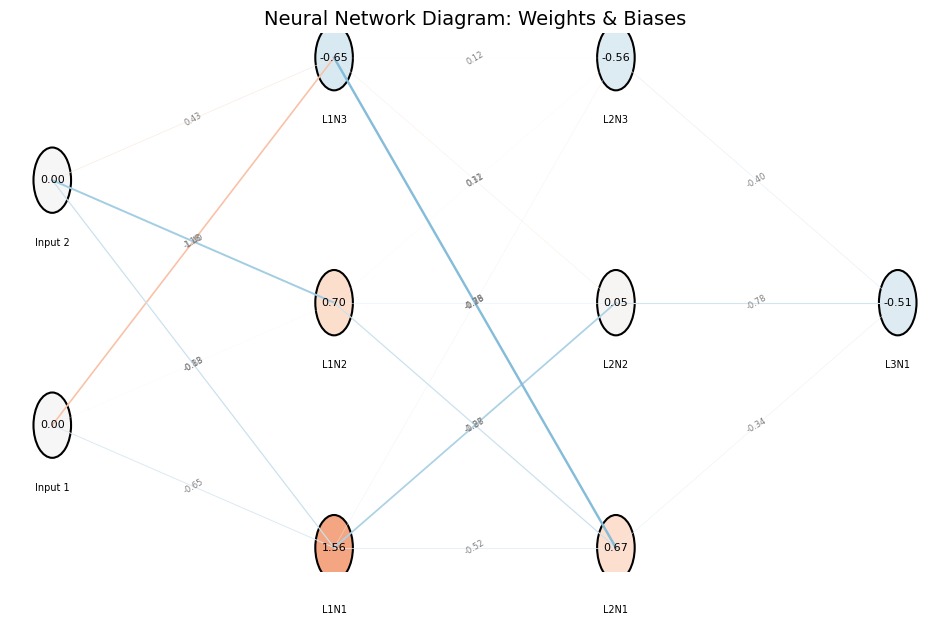

In [267]:
L = 3
n = [2, 3, 3, 1]


W1 = np.random.randn(n[1], n[0])
W2 = np.random.randn(n[2], n[1])
W3 = np.random.randn(n[3], n[2])

b1 = np.random.randn(n[1], 1)
b2 = np.random.randn(n[2], 1)
b3 = np.random.randn(n[3], 1)

weights = [W1, W2, W3]
biases = [b1, b2, b3]

plot.draw_network(n, weights, biases)

This neural network has four layers: an input layer, two hidden layers, and an output layer. The input layer has 2 neurons (representing the two input features), each hidden layer has 3 neurons, and the output layer has 1 neuron.

Each layer is made up of neurons, which are connected to the next layer by weights. These weights determine how much influence one neuron has on the next. Every neuron also has a bias, which helps shift the output of the neuron up or down. During training, the network learns by adjusting these weights and biases to better match the correct output.

The structure you see in the plot is a visual representation of the network: neurons are circles, connections are lines, and their colors represent the values of the weights and biases.

### Input data

In a neural network, the input data is a collection of examples. Each example has a set of features --- these could be anything from pixel values in an image to measurements in a dataset.

The data is usually organized as a matrix where:
- Each column is one example
- Each row is one feature

The output labels are the target values the network is trying to predict. These are often organized the same way --- one column per example, one row per output unit.

To make the math work nicely in training, we often reshape or transpose the data into this consistent format:
- Inputs: a matrix of shape (number of features, number of examples)
- Outputs: a matrix of shape (number of output units, number of examples)

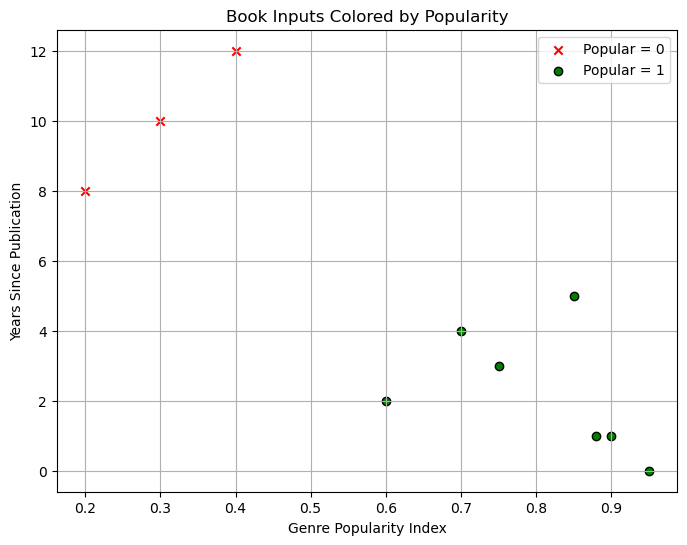

In [268]:
# X: [Genre Popularity Index, Years Since Publication]
X = np.array([
  [0.90, 1],
  [0.75, 3],
  [0.30, 10],
  [0.85, 5],
  [0.60, 2],
  [0.95, 0],
  [0.40, 12],
  [0.70, 4],
  [0.20, 8],
  [0.88, 1]
])
# y: 1 = popular, 0 = not popular
y = np.array([1, 1, 0, 1, 1, 1, 0, 1, 0, 1])
m = 10
A0 = X.T
Y = y.reshape(n[L], m)

plot.plot_inputs_by_output(A0, y)


For our example, we have 10 books (examples), and 2 features --- genre popularity index, and years since publication. 

The output is very simple and only has two labels. It is either:
- 1: popular
- 0: not popular

#### Activation function
Before walking into the actual feed forward process through layers, there's another very important feature in neural networks: activation functions. The activation function itself is what gives a neural network its ability to learn and model complex patterns. 

At each neuron, the network calculates a weighted sum of its inputs and then applies an activation function to that result. This function decides whether the neuron should “fire” or not --- kind of like flipping a switch, but with more nuance.

Having an activation function helps us with two things:
- Introduce non-linearity, so that the network is not doing linear calculation like mx + b all the time and is able to learn nonlinear functions;
- Compress the input to a predetermined range, like 0 to 1, so that it is standarized.

One common activation function that we'll be using is sigmoid, which squeezes numbers into 0-1 range that represents a probability as output.
$$
g(x) = \frac{1}{1 + e^{-x}}
$$

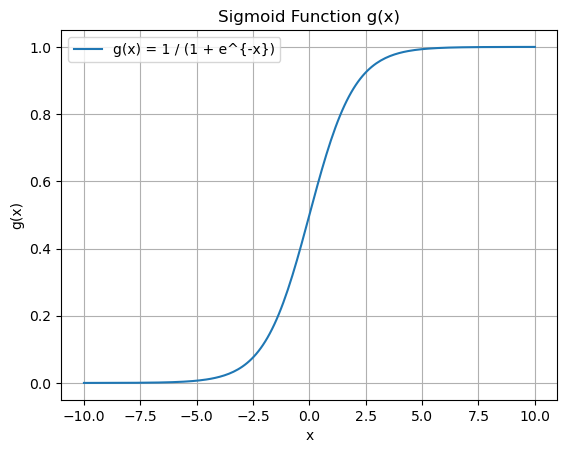

In [269]:
def g(z):
  return 1 / (1 + np.exp(-1 * z))
plot.draw_g()


With that, we are now able to understand how one feed forward layer works:

##### Example of one feed forward layer:

![complete perceptron model](complete_model.png)

#### So, what's the math behind this?

$
z_{[l]} = W_{[l]} \, a_{[l-1]} + b_{[l]}
$

$
a_{[l]} = g(z_{[l]}) \quad (0 < a_{[l]} < 1)
$

where:

- **a[l]** (*activation vector*): output of neurons after applying the activation function at layer \(l\).
- **z[l]** (*weighted input*): output before applying the activation function at layer \(l\), or the linear combination of activations from the previous layer.
- **W[l]** (*weight matrix*): all weights for connections from layer \(l-1\) to layer \(l\).
- **b[l]** (*bias vector*): all biases added at layer \(l\).
- **g()** (*activation function*): the sigmoid function in our case


In short: the input layer feeds in the data, hidden layers transform it using weights, biases and activation function, and the output layer delivers the final prediction. 


In [270]:
def feed_forward(A0):
  # layer 1 calculations
  Z1 = W1 @ A0 + b1
  A1 = g(Z1)

  # layer 2 calculations
  Z2 = W2 @ A1 + b2
  A2 = g(Z2)

  # layer 3 calculations
  Z3 = W3 @ A2 + b3
  A3 = g(Z3)

  cache = {
      "A0": A0,
      "A1": A1,
      "A2": A2
  }

  return A3, cache

### Backpropagation (aka the fun part)
After the feedforward process computes the output of the network using a randomly generated weights and biases, the next step is to evaluate how good that output is and adjust itself to make it better. This is what we call the backpropagation.

#### Cost
A cost function measures how far off the network's predictions are from the actual answers. It takes the network's output and compares it to the true labels, returning a number — the cost — that tells us how "bad" the predictions are. The lower, the better, and a cost of 0 indicates that your neural network made no mistakes.

We chose the binary cross entropy loss function as the cost function for our model:

$
L(\hat{y}_i, y_i) = - \left( y_i \ln \hat{y}_i + (1 - y_i) \ln (1 - \hat{y}_i) \right)
$

where,
- $(y_i)$ is the true label (either 0 or 1)
- $(\hat{y}_i)$ is the predicted probability that the label is 1 (a value between 0 and 1)    


The function outputs a higher loss when the prediction is confidently wrong, and a lower loss when it is confidently right.

But how does this work?

If $(y_i = 1)$:
$
L = -\ln(\hat{y}_i)
$
- If $(\hat{y}_i)$ is close to 1 → loss is small (good)
- If $(\hat{y}_i)$ is close to 0 → loss is large (bad)

If $(y_i = 0)$:
$
L = -\ln(1 - \hat{y}_i)
$
- If $(\hat{y}_i)$ is close to 0 → loss is small (good)
- If $(\hat{y}_i)$ is close to 1 → loss is large (bad)

The binary cross entropy loss model is ideal because:
1) the function is continuous, differentiable, and has no local maximun or minimum, which makes it very friendly for optimization
2) the loss approaches 0 when y and y_hat gets closer

Since our ground truth labels y are binary (either 0 or 1), plotting the loss against y_hat for y = 1 and y = 0 can illustrate this pattern very clearly:

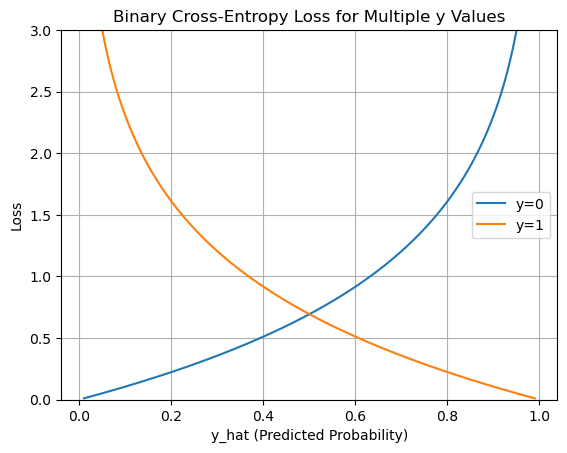

In [271]:
plot.draw_cost_function()

- When $y = 1$ (orange line), the loss is low when $\hat{y}$ is close to 1 (a correct, confident prediction), and very high when $\hat{y}$ is close to 0 (a confident but wrong prediction).
- When $y = 0$ (blue line), the opposite is true: loss is low when $\hat{y}$ is near 0, and high when $\hat{y}$ is near 1.


Now we can expand the cost function for a single pair of y and y_hat to the entire vectors:

$
C = \frac{1}{m} \sum_{i=1}^{m} L(\hat{y}_i, y_i) 
$
(Cost over all training samples)



In [272]:
def cost(y_hat, y):
  """
  y_hat should be a n^L x m matrix
  y should be a n^L x m matrix
  """
  # 1. losses is a n^L x m
  losses = - ( (y * np.log(y_hat)) + (1 - y)*np.log(1 - y_hat) )

  m = y_hat.reshape(-1).shape[0]

  # 2. summing across axis = 1 means we sum across rows, 
  #   making this a n^L x 1 matrix
  summed_losses = (1 / m) * np.sum(losses, axis=1)

  # 3. unnecessary, but useful if working with more than one node
  #   in output layer
  return np.sum(summed_losses)


#### But how do you actually train a neural network? 

Training a neural network means teaching it to make good predictions. To do that, we need to adjust its internal settings --- the weights and biases --- so that its output gets closer and closer to the correct answer.

You can think of the weights and biases like knobs and dials that control how the network behaves. Every connection between neurons has a weight that controls how strongly one neuron affects another. Each neuron also has a bias — an extra value it can use to shift its output up or down. Together, these weights and biases determine what kind of patterns the network is able to learn.

At first, the network starts off with random weights and biases, so its predictions are basically guesses. But after each prediction, we calculate how far off it was --- that’s what the cost function measures. The higher the cost, the worse the prediction.

Now comes the key part: we use gradient descent to figure out how to tweak all those weights and biases to reduce the cost. This is done using a process called backpropagation, which calculates how much each weight and bias contributed to the error. Then, we adjust them --- just a little --- in the direction that would reduce the error.

This process repeats over and over: make a prediction, measure the error, update the weights and biases. Each time, the network gets a little better at predicting. Eventually, if training goes well, the cost becomes very low, and the network is able to make accurate predictions on new, unseen data.


### Now, let's do this step by step

#### Quick Reference: What do all the variables mean?

- $A^{[l]}$: the output (activation) of layer $l$ — shape is $(\text{number of neurons in layer } l, m)$  
- $Z^{[l]}$: the weighted input to layer $l$ before activation — same shape as $A^{[l]}$  
- $W^{[l]}$: the weight matrix for layer $l$ — shape is $(\text{neurons in layer } l, \text{neurons in layer } l-1)$  
- $b^{[l]}$: the bias vector for layer $l$ — shape is $(\text{neurons in layer } l, 1)$  
- $\delta^{[l]}$: the "error" signal for layer $l$ — same shape as $Z^{[l]}$  
- $Y$: the ground truth (target values) — shape is $(1, m)$  
- $\hat{Y} = A^{[3]}$: the predicted output  
- $m$: the number of training examples in the batch  
- $\alpha$: the learning rate  
- $\circ$: elementwise (Hadamard) product  


#### Before we get to the hard part:

Let's break this down a bit to help us make sure we're staying on the right track as we go through these equations. We're computing the gradient of the cost function with respect to weights and biases at each layer.  
Each gradient must have the same shape as the weight or bias it's updating — because we subtract them elementwise:

$\text{size} \left( \frac{\partial \mathcal{L}}{\partial W^{[l]}} \right) = \text{size of } W^{[l]}$  
$\text{size} \left( \frac{\partial \mathcal{L}}{\partial b^{[l]}} \right) = \text{size of } b^{[l]}$

This is important: if $W^{[l]}$ is a $3 \times 2$ matrix, then the gradient must also be $3 \times 2$, so we can update each entry of the matrix with its corresponding gradient. The same applies for biases.


#### Step 1: Output Layer

Let $A^{[3]} = \hat{Y}$

1. Derivative of loss with respect to output activation:

$\frac{\partial \mathcal{L}}{\partial A^{[3]}} = A^{[3]} - Y$  

This tells us how far off our predicted output is from the actual value. It’s the derivative of the squared error loss function, which is simple but powerful for regression tasks.

2. Error signal (backpropagated through the activation):

$\delta^{[3]} = (A^{[3]} - Y) \circ \sigma'(Z^{[3]}) = (A^{[3]} - Y) \circ A^{[3]}(1 - A^{[3]})$

We now pass that loss through the derivative of the sigmoid function. This accounts for how sensitive the output neuron was: the more "saturated" it is (i.e. output is near 0 or 1), the less impact the error has on the weights.

3. Gradients:

$\frac{\partial \mathcal{L}}{\partial W^{[3]}} = \delta^{[3]} \cdot (A^{[2]})^T$  
$\frac{\partial \mathcal{L}}{\partial b^{[3]}} = \delta^{[3]}$

The weight gradient is calculated by multiplying the error signal by the activations from the previous layer. This tells us how much each connection between layer 2 and the output contributed to the error. For biases, the gradient is simply the error signal itself, since biases are added directly.

- $\delta^{[3]}$ has shape $(1, m)$ (1 output neuron, m examples)  
- $A^{[2]}$ has shape $(3, m)$ (3 neurons in previous layer)  
- So: $\frac{\partial \mathcal{L}}{\partial W^{[3]}}$ has shape $(1, 3)$ — same as $W^{[3]}$

#### Step 2: Hidden Layer 2

Backpropagate the error from the output layer to the second hidden layer:

$\delta^{[2]} = (W^{[3]})^T \delta^{[3]} \circ \sigma'(Z^{[2]}) = (W^{[3]})^T \delta^{[3]} \circ A^{[2]}(1 - A^{[2]})$

We multiply the transposed weight matrix from the next layer by the error signal. This tells us how much each neuron in layer 2 contributed to the output error. Then we scale it by the derivative of the activation function (sigmoid) to account for how responsive each neuron was.

Now we compute the gradients:

$\frac{\partial \mathcal{L}}{\partial W^{[2]}} = \delta^{[2]} \cdot (A^{[1]})^T$  
$\frac{\partial \mathcal{L}}{\partial b^{[2]}} = \delta^{[2]}$

This is the same procedure as before: multiply the error signal by the activations from the layer before to get the gradient of the weights.

- $\delta^{[2]}$ has shape $(3, m)$ → 3 neurons in layer 2  
- $A^{[1]}$ has shape $(3, m)$  
- So: $\frac{\partial \mathcal{L}}{\partial W^{[2]}}$ has shape $(3, 3)$ — same as $W^{[2]}$

#### Step 3: Hidden Layer 1

Continue backpropagating the error:

$\delta^{[1]} = (W^{[2]})^T \delta^{[2]} \circ \sigma'(Z^{[1]}) = (W^{[2]})^T \delta^{[2]} \circ A^{[1]}(1 - A^{[1]})$

Same idea: we take the error from the next layer, pass it through the transpose of the weight matrix, and multiply it elementwise by the derivative of the activation.

Now compute the gradients for this layer:

$\frac{\partial \mathcal{L}}{\partial W^{[1]}} = \delta^{[1]} \cdot (A^{[0]})^T$  
$\frac{\partial \mathcal{L}}{\partial b^{[1]}} = \delta^{[1]}$

Again, we multiply the error signal by the activations from the previous layer.

- $\delta^{[1]}$ has shape $(3, m)$  
- $A^{[0]}$ has shape $(2, m)$ (the input)  
- So: $\frac{\partial \mathcal{L}}{\partial W^{[1]}}$ has shape $(3, 2)$ — same as $W^{[1]}$

#### Step 4: Parameter Update (Gradient Descent)

Once we’ve computed all the gradients, we update our weights and biases to reduce the loss:

$W^{[l]} := W^{[l]} - \alpha \cdot \frac{\partial \mathcal{L}}{\partial W^{[l]}}$  
$b^{[l]} := b^{[l]} - \alpha \cdot \frac{\partial \mathcal{L}}{\partial b^{[l]}}$

Here, $\alpha$ is the learning rate — a small number (like 0.1 or 0.01) that controls how much we update the weights at each step.

Each weight and bias is updated elementwise using its corresponding gradient.

This completes the full backpropagation pass through a 3-layer neural network.


In [273]:
def backprop_layer_3(y_hat, Y, m, A2, W3):
  A3 = y_hat
  
  # step 1. calculate dC/dZ3 using shorthand we derived earlier
  dC_dZ3 = (1/m) * (A3 - Y)
  assert dC_dZ3.shape == (n[3], m)


  # step 2. calculate dC/dW3 = dC/dZ3 * dZ3/dW3 
  #   we matrix multiply dC/dZ3 with (dZ3/dW3)^T
  dZ3_dW3 = A2
  assert dZ3_dW3.shape == (n[2], m)

  dC_dW3 = dC_dZ3 @ dZ3_dW3.T
  assert dC_dW3.shape == (n[3], n[2])

  # step 3. calculate dC/db3 = np.sum(dC/dZ3, axis=1, keepdims=True)
  dC_db3 = np.sum(dC_dZ3, axis=1, keepdims=True)
  assert dC_db3.shape == (n[3], 1)

  # step 4. calculate propagator dC/dA2 = dC/dZ3 * dZ3/dA2
  dZ3_dA2 = W3 
  dC_dA2 = W3.T @ dC_dZ3
  assert dC_dA2.shape == (n[2], m)
  return dC_dW3, dC_db3, dC_dA2

def backprop_layer_2(propagator_dC_dA2, A1, A2, W2):

  # step 1. calculate dC/dZ2 = dC/dA2 * dA2/dZ2

  # use sigmoid derivation to arrive at this answer:
  #   sigmoid'(z) = sigmoid(z) * (1 - sigmoid(z))
  #     and if a = sigmoid(z), then sigmoid'(z) = a * (1 - a)
  dA2_dZ2 = A2 * (1 - A2)
  dC_dZ2 = propagator_dC_dA2 * dA2_dZ2
  assert dC_dZ2.shape == (n[2], m)


  # step 2. calculate dC/dW2 = dC/dZ2 * dZ2/dW2 
  dZ2_dW2 = A1
  assert dZ2_dW2.shape == (n[1], m)

  dC_dW2 = dC_dZ2 @ dZ2_dW2.T
  assert dC_dW2.shape == (n[2], n[1])

  # step 3. calculate dC/db2 = np.sum(dC/dZ2, axis=1, keepdims=True)
  dC_db2 = np.sum(dC_dW2, axis=1, keepdims=True)
  assert dC_db2.shape == (n[2], 1)

  # step 4. calculate propagator dC/dA1 = dC/dZ2 * dZ2/dA1
  dZ2_dA1 = W2
  dC_dA1 = W2.T @ dC_dZ2
  assert dC_dA1.shape == (n[2], m)

  return dC_dW2, dC_db2, dC_dA1

def backprop_layer_1(propagator_dC_dA1, A1, A0, W1):

  # step 1. calculate dC/dZ1 = dC/dA1 * dA1/dZ1

  # use sigmoid derivation to arrive at this answer:
  #   sigmoid'(z) = sigmoid(z) * (1 - sigmoid(z))
  #     and if a = sigmoid(z), then sigmoid'(z) = a * (1 - a)
  dA1_dZ1 = A1 * (1 - A1)
  dC_dZ1 = propagator_dC_dA1 * dA1_dZ1
  assert dC_dZ1.shape == (n[1], m)


  # step 2. calculate dC/dW1 = dC/dZ1 * dZ1/dW1 
  dZ1_dW1 = A0
  assert dZ1_dW1.shape == (n[0], m)

  dC_dW1 = dC_dZ1 @ dZ1_dW1.T
  assert dC_dW1.shape == (n[1], n[0])

  # step 3. calculate dC/db1 = np.sum(dC/dZ1, axis=1, keepdims=True)
  dC_db1 = np.sum(dC_dW1, axis=1, keepdims=True)
  assert dC_db1.shape == (n[1], 1)

  return dC_dW1, dC_db1

### Like a puzzle!

The `train()` function is where everything comes together.

- First, the network makes a prediction using the feed forward step.
- Then, we calculate the cost --- how far off the prediction is from the correct answer.
- After that, we use backpropagation to compute the gradients --- how each weight and bias should change to reduce the cost.
- Finally, we update the weights and biases using gradient descent, moving a little closer to a better prediction.

This loop repeats over many epochs (iterations), gradually improving the network’s accuracy.

The result is a list of cost values over time, which we can plot to visualize how well the network is learning.


In [274]:
# set learning rate to 0.1 for now

def train(alpha=0.1):
  # must use global keyword in order to modify global variables
  global W3, W2, W1, b3, b2, b1

  epochs = 2000 # training for 1000 iterations
  costs = [] # list to store costs

  for e in range(epochs):
    # 1. FEED FORWARD
    y_hat, cache = feed_forward(A0)
    
    # 2. COST CALCULATION
    error = cost(y_hat, Y)
    costs.append(error)

    # 3. BACKPROP CALCULATIONS

    dC_dW3, dC_db3, dC_dA2 = backprop_layer_3(
        y_hat, 
        Y, 
        m, 
        A2= cache["A2"], 
        W3=W3
    )

    dC_dW2, dC_db2, dC_dA1 = backprop_layer_2(
        propagator_dC_dA2=dC_dA2, 
        A1=cache["A1"],
        A2=cache["A2"],
        W2=W2
    )

    dC_dW1, dC_db1 = backprop_layer_1(
        propagator_dC_dA1=dC_dA1, 
        A1=cache["A1"],
        A0=cache["A0"],
        W1=W1
    )

    # 4. UPDATE WEIGHTS
    W3 = W3 - (alpha * dC_dW3)
    W2 = W2 - (alpha * dC_dW2)
    W1 = W1 - (alpha * dC_dW1)

    b3 = b3 - (alpha * dC_db3)
    b2 = b2 - (alpha * dC_db2)
    b1 = b1 - (alpha * dC_db1)

  return costs

In [275]:
costs = train()

After training the network, we can plot the cost (or loss) over each epoch to see how well the model is learning.

- The x-axis shows the number of epochs — how many times the model has seen the full dataset.
- The y-axis shows the cost --- how far off the model's predictions are from the true labels.

If training is going well, the cost should go down over time, meaning the model is getting better at making accurate predictions.

A smooth downward curve means the network is learning steadily. If the curve flattens out, it might mean the network has finished learning. If the cost goes up or bounces around a lot, the learning rate might be too high, or the network might be struggling to find a good solution.


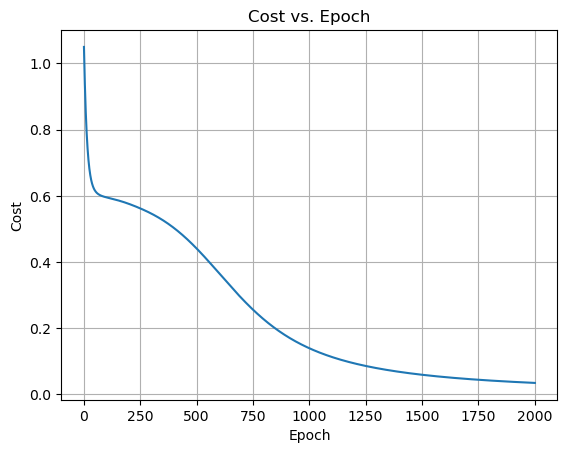

In [276]:
# Generate epochs based on costs length
epochs = range(1, len(costs) + 1)
plot.plot_epochs_costs(epochs, costs)

### Learning rate
The learning rate controls how big the steps are when updating the weights and biases during training.
If it's too small. the training will be very slow and need too many iterations; if it's too big, the model can overshoot optimal points or even make the cost increase instead of decrease.
In our case, we set its value, $\alpha$, to 0.1. Let's see what will happen if we set it to other values.


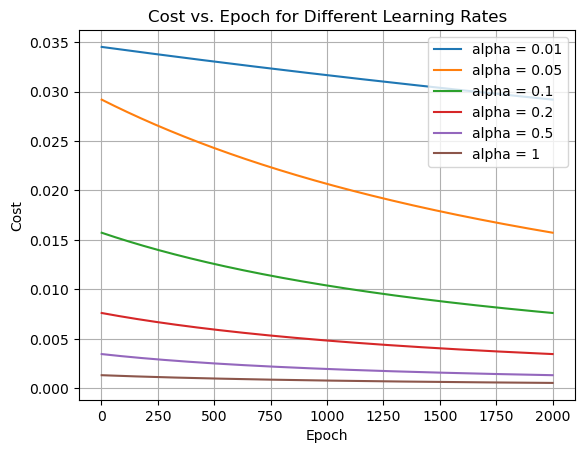

In [277]:
alpha_values = [0.01, 0.05, 0.1, 0.2, 0.5, 1]  # Try different learning rates
costs_by_alpha = {}

# Train with each alpha and store the costs
for alpha in alpha_values:
    costs = train(alpha=alpha)
    costs_by_alpha[alpha] = costs

# Plot all curves
for alpha, costs in costs_by_alpha.items():
    epochs = range(1, len(costs) + 1)
    plt.plot(epochs, costs, label=f'alpha = {alpha}')

plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.title('Cost vs. Epoch for Different Learning Rates')
plt.legend()
plt.grid(True)
plt.show()

The graph clearly shows the pattern we mentioned earlier. In our model, large alpha values don’t seem to cause problems, but this depends heavily on the activation and cost functions used, and it’s not always the case. That’s why choosing a proper alpha is important for training a good neural network. There are also more advanced algorithms that adjust alpha during training using more complex math, but we won’t go into that here.

### Conclusion

By building and training a simple neural network from scratch, we've broken down what can often feel like a black box into understandable parts — inputs, weights, biases, activations, and gradients. 

Along the way, we saw how the network learns by adjusting itself to reduce error, step by step. While this was a small example, the same principles power the large-scale models we see in the real world.

Hopefully, this gave you a clearer picture of what’s really happening under the hood — and a foundation for exploring deeper concepts ahead.
